Missing Values:
Age                             0
Gender                          0
Attendance                      0
CGPA                            0
Study_Hours                     0
Parental_Support                0
Marks                           0
Emotional_Support               0
Extra_Curricular_Involvement    0
Social_Connections              0
Parent_Education                0
Health_Condition                0
Stress_Levels                   0
dtype: int64
Performance Prediction Accuracy: 0.7142857142857143
Well-being Prediction Accuracy: 1.0
Holistic Development Prediction Accuracy: 1.0


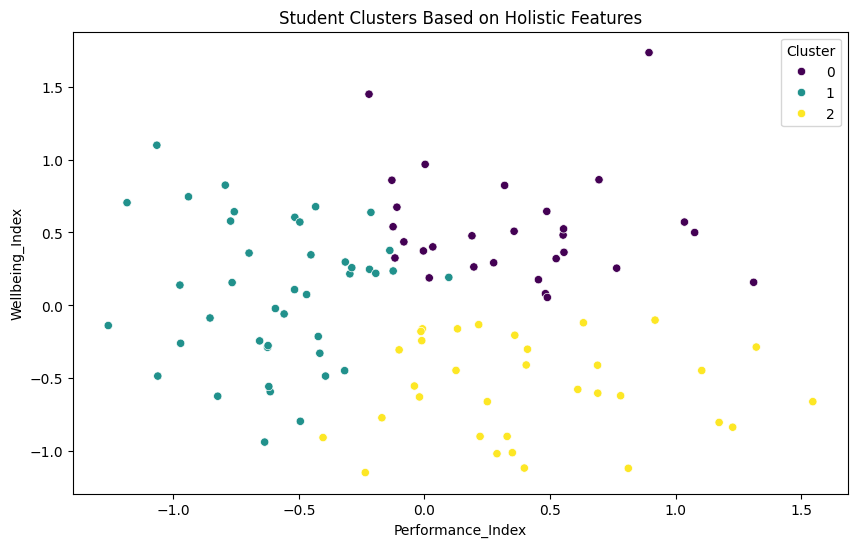

{'Performance Prediction Accuracy': 0.7142857142857143, 'Well-being Prediction Accuracy': 1.0, 'Holistic Development Prediction Accuracy': 1.0, 'Cluster Distribution': {1: 42, 2: 33, 0: 29}}


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans

# Load the dataset
data = pd.read_csv('File.csv')

# Step 1: Data Cleaning
# Drop non-numeric columns
data = data.drop(columns=['Name', 'ID'], errors='ignore')

# Check for missing values
missing_values = data.isnull().sum()
print(f"Missing Values:\n{missing_values}")

# Drop rows with missing values
data = data.dropna()

# Handle categorical variables
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])
data['Parent_Education'] = label_encoder.fit_transform(data['Parent_Education'])

# Standardize numerical columns
numerical_cols = ['Attendance', 'CGPA', 'Study_Hours', 'Parental_Support', 'Marks', 'Emotional_Support',
                  'Extra_Curricular_Involvement', 'Social_Connections', 'Health_Condition', 'Stress_Levels']
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Step 2: Feature Engineering
# Performance Index
data['Performance_Index'] = data['Marks'] * 0.5 + data['CGPA'] * 0.3 + data['Attendance'] * 0.2

# Well-being Index
data['Wellbeing_Index'] = data['Health_Condition'] * 0.4 - data['Stress_Levels'] * 0.3 + data['Emotional_Support'] * 0.3

# Add Involvement Index
data['Involvement_Index'] = (data['Extra_Curricular_Involvement'] * 0.6 +
                             data['Social_Connections'] * 0.4)

# Holistic Development Index
data['Holistic_Development_Index'] = (
    data['Wellbeing_Index'] * 0.4 +
    data['Performance_Index'] * 0.4 +
    data['Involvement_Index'] * 0.2
)

# Add interaction term: Marks * Attendance
data['Marks_Attendance_Interaction'] = data['Marks'] * data['Attendance']

# Add another interaction term: Study_Hours * Parental_Support
data['Study_Hours_Parental_Support_Interaction'] = data['Study_Hours'] * data['Parental_Support']

# Step 3: Voting Classifiers for Predictions
# Features for prediction
X = data[['Marks', 'Attendance', 'Study_Hours', 'Parental_Support', 'Emotional_Support',
          'Performance_Index', 'Wellbeing_Index', 'Involvement_Index',
          'Marks_Attendance_Interaction', 'Study_Hours_Parental_Support_Interaction']]

# Performance Prediction (CGPA Level)
y_performance = (data['CGPA'] > 0).astype(int)

# Well-being Prediction
y_wellbeing = (data['Wellbeing_Index'] > 0).astype(int)

# Holistic Development Prediction
y_holistic = (data['Holistic_Development_Index'] > 0).astype(int)

# Train-Test Split
X_train, X_test, y_performance_train, y_performance_test = train_test_split(X, y_performance, test_size=0.2, random_state=42)
_, _, y_wellbeing_train, y_wellbeing_test = train_test_split(X, y_wellbeing, test_size=0.2, random_state=42)
_, _, y_holistic_train, y_holistic_test = train_test_split(X, y_holistic, test_size=0.2, random_state=42)

# Initialize classifiers
log_clf = LogisticRegression(random_state=42)
knn_clf = KNeighborsClassifier()
dt_clf = DecisionTreeClassifier(random_state=42)

# Voting Classifier for Performance Prediction
performance_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('knn', knn_clf), ('dt', dt_clf)],
    voting='hard'
)
performance_clf.fit(X_train, y_performance_train)
y_performance_pred = performance_clf.predict(X_test)

# Voting Classifier for Well-being Prediction
wellbeing_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('knn', knn_clf), ('dt', dt_clf)],
    voting='hard'
)
wellbeing_clf.fit(X_train, y_wellbeing_train)
y_wellbeing_pred = wellbeing_clf.predict(X_test)

# Voting Classifier for Holistic Development Prediction
holistic_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('knn', knn_clf), ('dt', dt_clf)],
    voting='hard'
)
holistic_clf.fit(X_train, y_holistic_train)
y_holistic_pred = holistic_clf.predict(X_test)

# Evaluate Models
performance_accuracy = accuracy_score(y_performance_test, y_performance_pred)
wellbeing_accuracy = accuracy_score(y_wellbeing_test, y_wellbeing_pred)
holistic_accuracy = accuracy_score(y_holistic_test, y_holistic_pred)

print("Performance Prediction Accuracy:", performance_accuracy)
print("Well-being Prediction Accuracy:", wellbeing_accuracy)
print("Holistic Development Prediction Accuracy:", holistic_accuracy)

# Step 4: Clustering for Holistic Segmentation
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(data[['Performance_Index', 'Wellbeing_Index', 'Holistic_Development_Index']])

# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Performance_Index', y='Wellbeing_Index', hue='Cluster', data=data, palette='viridis')
plt.title('Student Clusters Based on Holistic Features')
plt.show()

# Step 5: Insights
insights = {
    'Performance Prediction Accuracy': performance_accuracy,
    'Well-being Prediction Accuracy': wellbeing_accuracy,
    'Holistic Development Prediction Accuracy': holistic_accuracy,
    'Cluster Distribution': data['Cluster'].value_counts().to_dict()
}

print(insights)
